In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns

In [119]:
data = pd.read_csv("preterm.csv")
data.head()

,Count Contraction,lenght of contraction,STD,Entropy,Contraction times,Pre-term
0,11055,218320,53231.010,1.860,2,1
1,9118,222820,62367.488,1.580,2,1
2,7925,13481,60503.050,2.067,2,1
3,12451,17474,53628.078,1.731,2,1
4,11152,218320,53317.910,1.857,2,1


In [121]:
data.dropna(inplace=True)

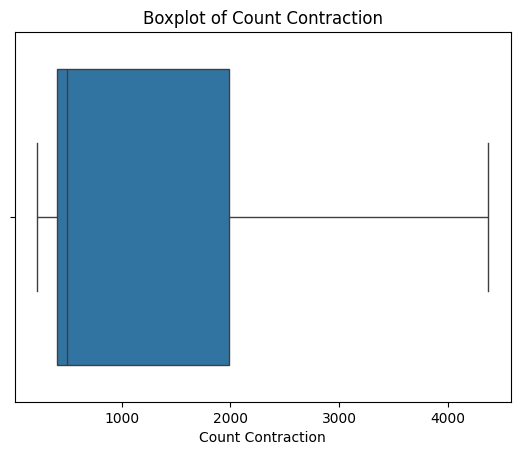

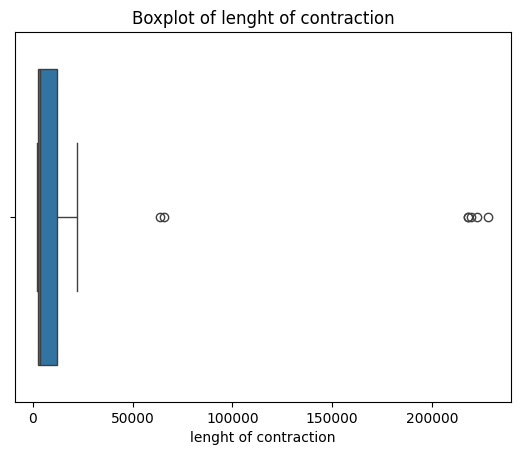

In [123]:
columns_to_check = ["Count Contraction","lenght of contraction"]
for column in columns_to_check:
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

In [124]:
X = data.iloc[:, :-1] #first and second columns
y = data.iloc[:, -1] #last column

train_size = int(len(X) * 0.75)  # %65 train, %35 test
X_train, X_test = X[:train_size], X[train_size:] # Now this should work correctly
y_train, y_test = y[:train_size], y[train_size:]

In [125]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [126]:
model = XGBRegressor()
model.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [127]:
y_pred = model.predict(X_test_scaled)

In [128]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 0.0001348604419035837


In [129]:
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees
    'max_depth': [3, 4, 5],               # Maximum tree depth
    'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
    'gamma': [0, 0.1, 0.2],               # Minimum loss reduction required to make a further partition on a leaf node
    'subsample': [0.8, 0.9, 1.0],         # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 0.9, 1.0]   # Subsample ratio of columns when constructing each tree
}

In [130]:
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid_result = grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_result.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}


In [131]:
best_params = grid_result.best_params_
final_model = XGBRegressor(**best_params)
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)

In [132]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Final RMSE:", rmse)

Final RMSE: 0.00013108538405504078
